In [18]:
from detr_config import Config
from detr_factory import DETRFactory
from detr_file_manager import FileManager
from detr_model_loader import ModelLoader
from detr_data_source import DataSource
from detr_model_evaluator import ModelEvaluator
from detr_metrics import MetricsAggregator, metrics_names
from detr_detection import plot_comparison
import matplotlib.pyplot as plt
import numpy as np


Config.set_local_settings()

In [22]:
hyperparameters = ('D-DETR', 100, 6)
detr_factory = DETRFactory(*hyperparameters)
file_manager = FileManager(detr_factory)
model_loader = ModelLoader(detr_factory, file_manager)
data_source = DataSource(detr_factory, file_manager)
metrics_aggregator = MetricsAggregator(file_manager)

file_manager.set_testing_setup()
model = model_loader.load_best_model()
id2label = model.detr.config.id2label
train_valid_dataset, train_valid_loader = data_source.get_train_valid_dataset_dataloader()
test_dataset, test_loader = data_source.get_test_dataset_dataloader()
batch = next(iter(test_loader))

Loading Model:  lightning_logs\model=D-DETR_queries=100_layers=6\test\checkpoints\epoch=7-step=48.ckpt
Loading Annotations from:  InBreast_Coco\train_valid\_annotations.coco.json
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading Annotations from:  InBreast_Coco\test\_annotations.coco.json
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


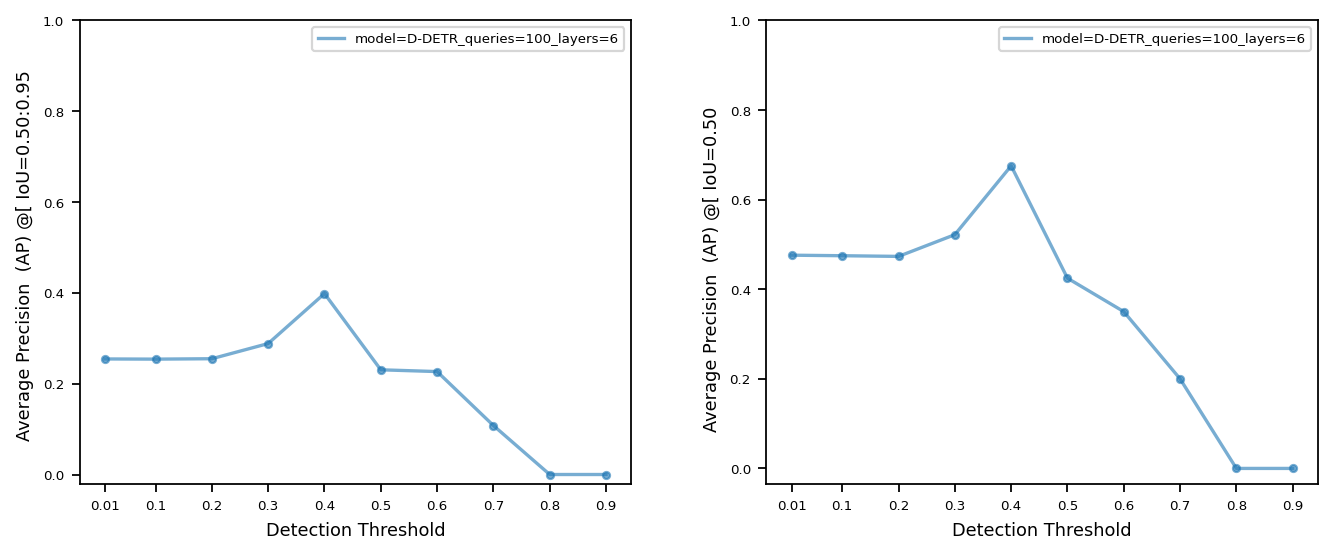

In [23]:
metrics = metrics_aggregator.load_metrics()

fig, axes = plt.subplots(1, 2, figsize=(9,4), dpi=160)
fig.tight_layout(pad=3)
axes = axes.flat

for i, metric in enumerate(metrics_names[0:2]):
    metrics_name = metric.split("|")[0]
    ax = axes[i]
    model_name = detr_factory.get_model_name()
    ax.plot(metrics.index, metrics[metric], alpha=0.6, label=model_name)
    ax.scatter(metrics.index, metrics[metric], alpha=0.6, s=10)
    
    ax.legend(fontsize=6)

    y_ticks = np.round(np.arange(0,1.1,0.2), 1)
    x_ticks = metrics.index
    ax.set_yticks(y_ticks, labels=y_ticks, fontsize=6)
    ax.set_xticks(x_ticks, labels=x_ticks, fontsize=6)

    ax.set_xlabel("Detection Threshold", fontsize=8)
    ax.set_ylabel(metrics_name, fontsize=8)

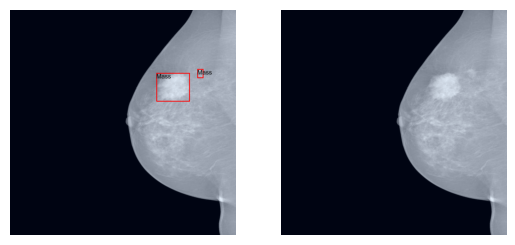

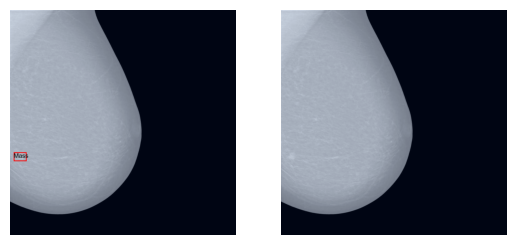

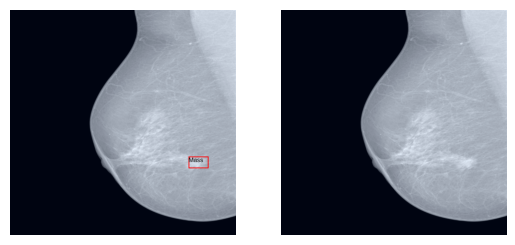

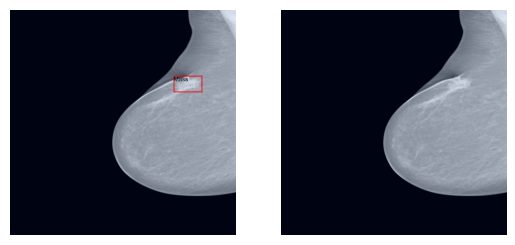

In [24]:
model_evaluator = ModelEvaluator(model, detr_factory)
batch_predictions = model_evaluator.generate_predictions(batch, threshold=0.2)
for i, (image_id, predictions) in enumerate(batch_predictions.items()):
    image, annotations = test_dataset.__getitem__(image_id)
    plot_comparison(image, annotations, predictions, id2label)
    if i == 3:
        break